In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


### Project

### Summary

### Package List

In [2]:
#import pkg_resources
#installed_packages = pkg_resources.working_set
#installed_packages_list = sorted(["%s==%s" % (i.key, i.version) for i in installed_packages])
#installed_packages_list

In [3]:
# Install Additional Packages
import io
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, LogisticRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
import xgboost

from statsmodels.stats.outliers_influence import OLSInfluence # Cook's Distance
from scipy import stats #Confidence Interval
import seaborn as sns

### Load Data

In [4]:
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
holdout_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
#data.shape
#holdout_data.shape

In [5]:
df = df[['SalePrice', 'KitchenQual', 'LotArea']]
#holdout_df = holdout_df[['SalePrice', 'KitchenQual', 'LotArea']]

## Functions

### Exploratory Data Analysis Functions

In [6]:
# Code to determine dtypes, missing values, etc...
def analysis(read):
    
    if len(read) > 0:
        print("PROCESS HAS BEEN STARTED\n")

        print("DATA SHAPE")
        print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")

        print("EXPLORE MORE ABOUT THE DATA")
        if len(read.select_dtypes("object").columns) > 0:
            print("Object Variables:", "\n", "Variables:", 
                  len(read.select_dtypes("object").columns), "\n", 
                  read.select_dtypes("object").columns.tolist(), "\n")

        if len(read.select_dtypes("integer").columns) > 0:
            print("Integer Variables:", "\n", "VVariables:", 
                  len(read.select_dtypes("integer").columns), "\n", 
                  read.select_dtypes("integer").columns.tolist(), "\n")

        if len(read.select_dtypes("float").columns) > 0:
            print("Float Variables:", "\n", "Variables:", 
                  len(read.select_dtypes("float").columns), "\n", 
                  read.select_dtypes("float").columns.tolist(), "\n")

        if len(read.select_dtypes("bool").columns) > 0:
            print("Bool Variables:", "\n", "Variables:", 
                  len(read.select_dtypes("bool").columns), "\n", 
                  read.select_dtypes("bool").columns.tolist(), "\n")

        print("IS THERE ANY MISSING VALUE")
        print(" \n ", np.where(read.isnull().values.any() == False,"No missing value!", "Data includes missing value!"), "\n")

        buf = io.StringIO()
        read.info(buf=buf)
        check = True
        check = buf.getvalue().split('\n')[-2].split(":")[1].strip()
        print("MEMORY \n", check)

    else:
        print("ERROR!")

    return read

In [7]:
# Inspect Missing Values
def data_cleaning(df):

    print("*********{} *********".format('Inspecting missing values'))
    
    data = df.isna().sum().reset_index().sort_values(by=0, ascending=False)
    clean_data = data[data[0] != 0].shape[0]
    columns = df.shape[1]
    rows = df.shape[0]
    data.columns = ["name", "missing appearences"]
    data["%missing from total"] = data[data["missing appearences"]!=0]["missing appearences"]/rows
    mis_data = data[data["%missing from total"] > 0.5].shape[0]
    #drop_data = np.array(data[data["%missing from total"] > 0.5]["name"])
    
    print("{}/{} total missing data in terms of column shape.".format(clean_data, columns))
    #print("{}/{} columns  will be dropped. name of the drop column is {}".format(mis_data, columns,drop_data))
    
    return data#, drop_data

In [8]:
def histogram_numerical_plots(data):
    data_x = data.copy()
    # Select numerical columns
    num_cols = data_x.select_dtypes(include=['int64', 'float64'])
    # Create subset DataFrame with only numerical values
    data_x_num_cols = data_x[num_cols.columns]
    data_x_num_cols.hist(bins=25, figsize=(40,30))
    plt.show()

In [9]:
# Pearson's R
def corr_matrix(data):
    data_x = data.copy()
    # Select numerical columns
    num_cols = data_x.select_dtypes(include=['int64', 'float64'])
    corr_cols = data_x[num_cols.columns]
    corr_matrix = corr_cols.corr()
    corr_matrix = corr_matrix["SalePrice"].sort_values(ascending=False)
    return corr_matrix

In [10]:
# Univariate Analysis (Compare Train/Test Splits)
def univariate_eda(data, target, var) -> dict:
    if data[var].dtype == 'object':
        data[var] = np.where(data[var].isna(), "NaN", data[var])
        train = data.loc[data['TRAIN_INDEX'] == 1]
        test = data.loc[data['TRAIN_INDEX'] == 0]
        train_grp = train[[var,target]].groupby(var).agg(['count','mean'])
        test_grp = test[[var,target]].groupby(var).agg(['count','mean'])
        grp = pd.merge(train_grp, test_grp, how='outer', left_index=True, right_index=True)
        grp.columns = ['count_train', 'severity_train', 'count_test', 'severity_test']
        print(grp)
        
        count_max = max([max(grp['count_train']),max(grp['count_test'])])
        sev_max = max([max(grp['severity_train']),max(grp['severity_test'])])
        
        df_count = grp[['count_train', 'count_test']].copy()
        df_sev = grp[['severity_train', 'severity_test']].copy()
        
        x = np.arange(len(df_count.index))
        width = 0.3
        multiplier = 0 
        
        fig, ax1 = plt.subplots(constrained_layout=True)
        
        for attribute, measurement in df_count.items():
            offset = width + multiplier
            rects = ax1.bar(x + offset, measurement, width, label=attribute)
            multiplier += 1
            
        ax1.set_title('numerical: ' + var)
        
        ax1.set_ylabel('Counts')
        ax1.set_xticks(x)
        ax1.set_xticklabels(df_count.index, rotation=90)
        ax1.legend(loc='upper left')
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('Severity')
        ax2.plot(df_sev.index, df_sev['severity_train'], c='blue', label='severity_train')
        ax2.plot(df_sev.index, df_sev['severity_test'], c='darkorange', label='severity_test')
        ax2.legend(loc='upper right')
    else:
        data_temp = data.copy()
        data_temp['DECILE'] = pd.qcut(data_temp[var], 10, labels=False, duplicates='drop')                   
        temp = data.copy()
        temp['DECILE'] = pd.qcut(temp[var], 10, duplicates='drop')
        data_grp = temp[['DECILE', target]].groupby('DECILE').agg(['count','mean']).reset_index()
        data_grp.columns = [var+'_BOUNDARY', 'count', 'severity']
        data_grp = data_grp.drop(['count', 'severity'], axis=1)
        
        train = data_temp.loc[data_temp['TRAIN_INDEX'] == 1]
        test = data_temp.loc[data_temp['TRAIN_INDEX'] == 0]
        
        train_temp = train.copy()
        train_grp = train_temp[['DECILE', target]].groupby('DECILE').agg(['count','mean'])
        train_grp.columns = ['count_train', 'severity_train']
        
        test_temp = test.copy()
        test_grp = test_temp[['DECILE', target]].groupby('DECILE').agg(['count','mean'])
        test_grp.columns = ['count_test', 'severity_test']
        
        grp = pd.merge(data_grp, train_grp, how='outer', left_index=True, right_index=True)
        grp = pd.merge(grp, test_grp, how='outer', left_index=True, right_index=True)
        
        df_count = grp[['count_train', 'count_test']].copy()
        df_sev = grp[['severity_train', 'severity_test']].copy()
        
        x = np.arange(len(df_count.index))
        width = 0.3
        multiplier = 0
        
        fig, ax1 = plt.subplots(constrained_layout=True)
        
        for attribute, measurement in df_count.items():
            offset = width * multiplier
            rects = ax1.bar(x + offset, measurement, width, label=attribute)
            multiplier +=1
            
        ax1.set_title('numerical: ' + var)
        
        ax1.set_ylabel('Counts')
        ax1.set_xticks(x)
        ax1.set_xticklabels(df_count.index, rotation=90)
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Severity')
        ax2.plot(df_sev.index, df_sev['severity_train'], label='severity_train')
        ax2.plot(df_sev.index, df_sev['severity_test'], label='severity_test')
        ax2.legend(loc='upper right')

#### Model Preparation Functions

In [11]:
def split_data(df, test_size=0.25, random_state=None):
    train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)
    train_data['TRAIN_INDEX'] = 1
    test_data['TRAIN_INDEX'] = 0
    train_test_data = pd.concat([train_data, test_data], ignore_index=True)
    print(f"Train data size: {train_data.shape}")
    print(f"Test data size: {test_data.shape}")
    print(f"Train/Test data size: {train_test_data.shape}")
    return train_data, test_data, train_test_data

### Modeling Performance Functions

In [12]:
def evaluation_metrics(actual, pred) -> dict:
    rmse = np.sqrt(np.mean(pred-actual)**2)
    me = np.mean(pred-actual)
    mep = np.mean(pred-actual)/np.mean(actual)
    return {"Root Mean Squared Error": rmse, "Mean Error": me, "Mean Error Percent": mep}

def lift_chart(data, pred, act) -> dict:
    data['Prediction_Decile'] = pd.qcut(data[pred], 20, labels=False, duplicates='drop')
    lift_chart_prediction = data.groupby('Prediction_Decile')[pred].mean().to_frame(name = 'pred').reset_index()
    lift_chart_actual = data.groupby('Prediction_Decile')[act].mean().to_frame(name = 'act').reset_index()
    lift_chart_data = pd.merge(lift_chart_prediction, lift_chart_actual, how='inner', left_on=['Prediction_Decile'], right_on=[])
    
    lift_chart_plot = plt.figsize()
    plt.plot(lift_chart_data['Prediction_Decile'], lift_chart_data['Prediction_Decile'], label = 'pred', color='red')
    plt.plot(lift_chart_data['Prediction_Decile'], lift_chart_data['Prediction_Decile'], label = 'act', color='black')
    plt.xlabel("Prediction Decile")
    plt.ylabel("Average Cost")
    plt.legend(loc="upper right")
    plt.gca().set_title("Model Performance Lift Chart")

In [13]:
# Understanding Outliers

## Cook's Distance

## Leverage



In [14]:
# Variable Correlation Analysis

## T-Testing

## Chi-Square Test

from scipy.stats import chi2_contingency

def chi_square_test(df, col1, col2):
    """
    Perform chi-square test of independence between two categorical variables in a DataFrame.

    Parameters:
    df (DataFrame): Pandas DataFrame containing the categorical variables.
    col1 (str): Name of the first categorical column.
    col2 (str): Name of the second categorical column.

    Returns:
    chi2_stat (float): The test statistic of the chi-square test.
    p_val (float): The p-value of the test.
    dof (int): Degrees of freedom.
    contingency_table (DataFrame): The contingency table showing the observed frequencies.
    """

    # Create contingency table
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    # Perform chi-square test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    return chi2_stat, p_val, dof, contingency_table

## P-Value Testing

## One-Way Analysis

## VIF Calculations

## Correlation Matrix

## Principal Component Analysis (PCA)

## 


In [15]:
# Execute Analysis, Data Cleaning Functions

# Create Train/Test/Holdout Dataframes
train_data, test_data, train_test_data = split_data(df, random_state=42)

output = analysis(train_data)
missing = data_cleaning(train_data)
missing_data = data_cleaning(train_data)
missing_data.head()

Train data size: (1095, 4)
Test data size: (365, 4)
Train/Test data size: (1460, 4)
PROCESS HAS BEEN STARTED

DATA SHAPE
Observation: 1095 Column: 4 

EXPLORE MORE ABOUT THE DATA
Object Variables: 
 Variables: 1 
 ['KitchenQual'] 

Integer Variables: 
 VVariables: 3 
 ['SalePrice', 'LotArea', 'TRAIN_INDEX'] 

IS THERE ANY MISSING VALUE
 
  No missing value! 

MEMORY 
 42.8+ KB
*********Inspecting missing values *********
0/4 total missing data in terms of column shape.
*********Inspecting missing values *********
0/4 total missing data in terms of column shape.


,name,missing appearences,%missing from total
0,SalePrice,0,NaN
1,KitchenQual,0,NaN
2,LotArea,0,NaN
3,TRAIN_INDEX,0,NaN


### Start Modeling Process 

### SalePrice Distribution (Target Variable)

In [16]:
train_data['SalePrice'].describe()
#train_data.info() - No Missing SalePrice

count      1095.000000
mean     181712.286758
std       77955.082565
min       34900.000000
25%      130000.000000
50%      165000.000000
75%      215000.000000
max      745000.000000
Name: SalePrice, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


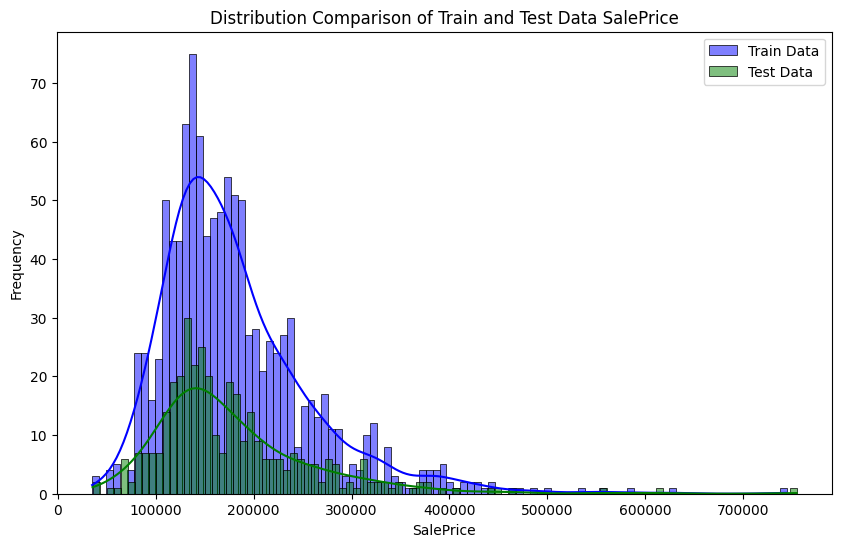

In [17]:
# Plotting SalePrice Distributions for Train/Test Data
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, color='blue', alpha=0.5, bins=100, label='Train Data')
sns.histplot(test_data['SalePrice'], kde=True, color='green', alpha=0.5, bins=100, label='Test Data')

# Customizing the plot
plt.title('Distribution Comparison of Train and Test Data SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.legend()
plt.show()

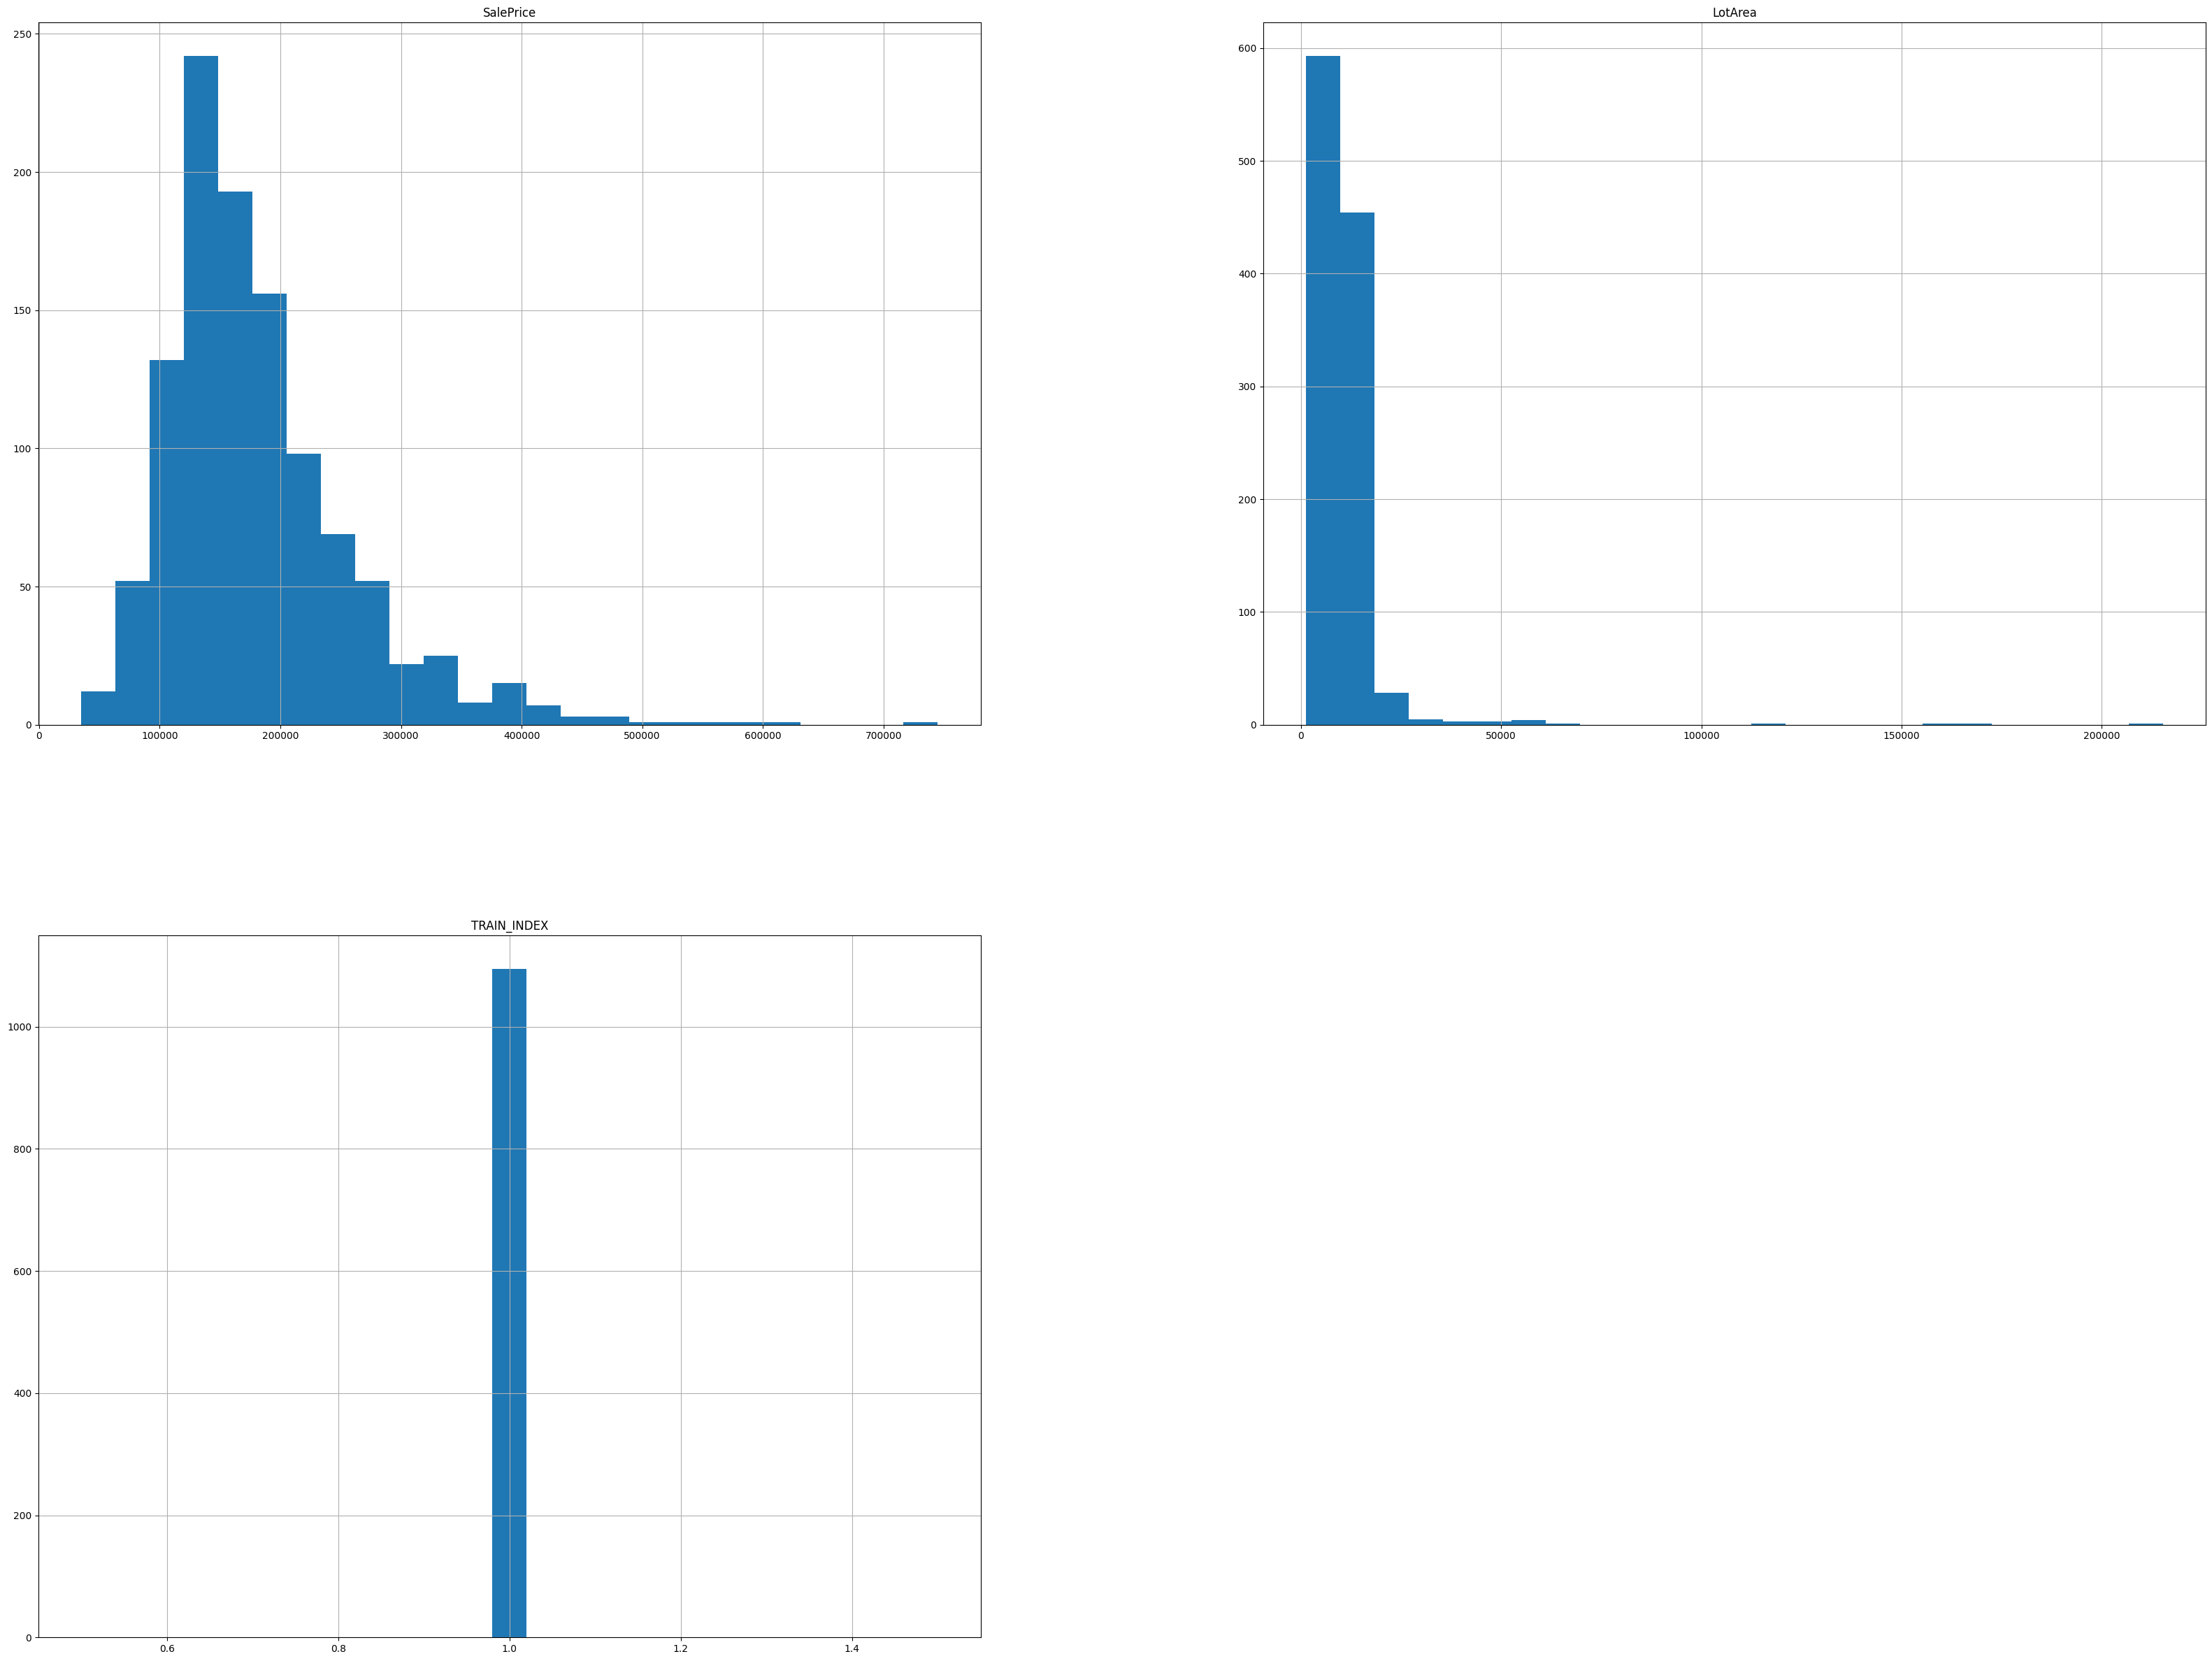

In [18]:
### Exploratory Data Analysis
histogram_numerical_plots(train_data)

In [19]:
### Pearson's R Plot
corr_matrix(train_data)

SalePrice      1.000000
LotArea        0.265577
TRAIN_INDEX         NaN
Name: SalePrice, dtype: float64

### Feature Engineering

In [ ]:
#all_variable_list = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
#                 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
#                 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 
#                 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
#                 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 
#                 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
#                 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
#                 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
#                 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt'] 

In [20]:
all_variable_list = ['LotArea', 'KitchenQual']

/tmp/ipykernel_655/1427411007.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grp = temp[['DECILE', target]].groupby('DECILE').agg(['count','mean']).reset_index()


             count_train  severity_train  count_test  severity_test
KitchenQual                                                        
Ex                    73   329083.931507          27  327123.703704
Fa                    32   107110.937500           7   98499.000000
Gd                   440   212196.709091         146  211872.863014
TA                   550   142104.954545         185  133593.086486


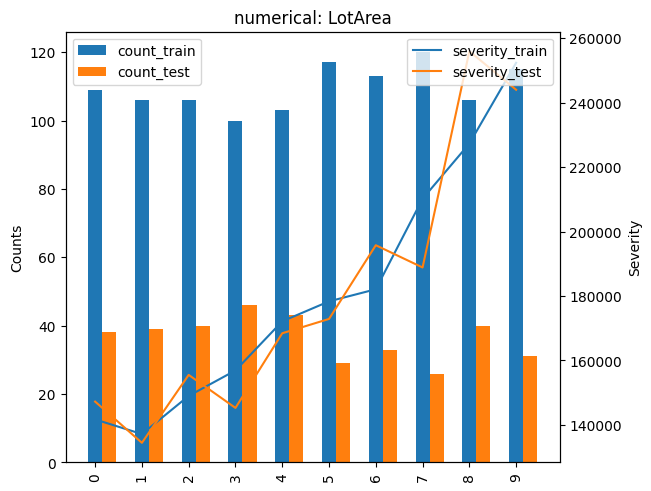

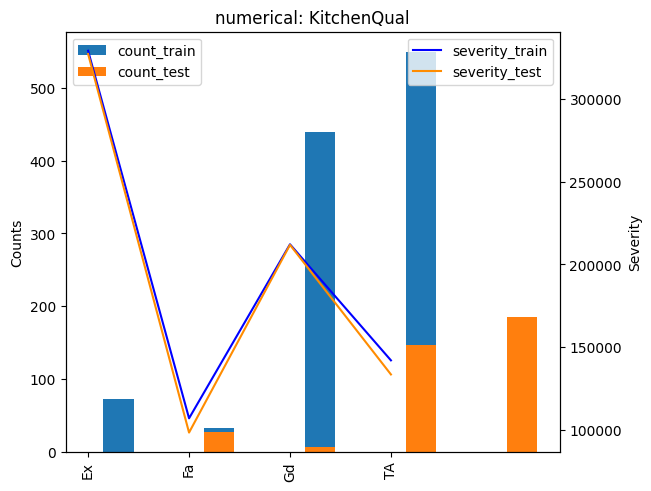

In [22]:
for var in all_variable_list:
    univariate_eda(train_test_data, 'SalePrice', var)

#### Numerical Variables

In [ ]:
### Continuous Variable Strategies
    
def log_transformation(data):
    
def sqrt_transformation(data):
    


### Data Transformer

In [23]:
X_train = train_data.drop(columns=['SalePrice'])  # Replace 'target_column_name' with your actual target column name
y_train = train_data['SalePrice']

X_test = test_data.drop(columns=['SalePrice'])
y_test = test_data['SalePrice']

In [24]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features = selected_features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.selected_features]

# Define selected features (numerical and categorical)
numerical_features = ['LotArea']
categorical_features = ['KitchenQual'] #['MSSubClass', 'LotArea', 'OverallQual']

# Create pipelines for numerical and categorical preprocessing
numerical_pipeline = Pipeline([
    ('num_selector', FeatureSelector(numerical_features)),
    ('imputer', SimpleImputer(strategy='median')),  # Mean Imputation
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('cat_selector', FeatureSelector(categorical_features)),
    ('encoder', OneHotEncoder())
])

# Combine numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

### Model Pipelines

In [26]:
## Step-Wise

## Tweedie
glm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('glm', LinearRegression())  # Replace with your GLM model
])

## Inverse Gaussian

## Logistic/Binomial

## Multinomial


In [ ]:
# GLM pipeline


# Lasso pipeline


### Create Modeling Functions

In [ ]:
# Naive Model

In [ ]:
# Random Forest

In [ ]:
# Decision Tree (CART)

In [28]:
# Lasso Model
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=0.1))  # Replace with your Lasso model and set alpha
])


In [ ]:
# Ridge Model


In [ ]:
# Elastic Net


In [ ]:
# Gradient Boosting Machine


In [ ]:
# Support Vector Machine


In [ ]:
# Neural Network


### Model Fitting

In [29]:
# Fit GLM pipeline
glm_pipeline.fit(X_train, y_train)

# Evaluate GLM pipeline
glm_score = glm_pipeline.score(X_test, y_test)
print(f"GLM Model R^2 Score: {glm_score}")

# Fit Lasso pipeline
lasso_pipeline.fit(X_train, y_train)

# Evaluate Lasso pipeline
lasso_score = lasso_pipeline.score(X_test, y_test)
print(f"Lasso Model R^2 Score: {lasso_score}")

GLM Model R^2 Score: 0.4927595267160194
Lasso Model R^2 Score: 0.4927590554628125


### Data Analysis